In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from itertools import product
from functools import reduce
from operator import methodcaller
from sklearn.preprocessing import StandardScaler

In [2]:
heroes = pd.read_csv('data/dictionaries/heroes.csv', index_col='id')

In [3]:
features = pd.read_csv('data/features.csv', index_col='match_id')

# Подход 1: градиентный бустинг "в лоб"

Удалены фичи, связанные с итогами матча.

In [4]:
df_1 = features.drop(['duration', 'radiant_win', 'tower_status_radiant',
                     'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis=1)

## Вопрос 1
**Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?**

In [5]:
n = df_1.shape[0]
counter = df_1.count()
print('Пропущенные значения есть в следующих столбцах:')
pd.DataFrame({'missing_values': n - counter[counter != n]})

Пропущенные значения есть в следующих столбцах:


,missing_values
first_blood_time,19553
first_blood_team,19553
first_blood_player1,19553
first_blood_player2,43987
radiant_bottle_time,15691
radiant_courier_time,692
radiant_flying_courier_time,27479
radiant_first_ward_time,1836
dire_bottle_time,16143
dire_courier_time,676


Пропуск в признаке *first_blood_time* означает, что событие "first blood" не наступило до конца пятой минуты.  
Пропуск в признаке *dire_courier_time* означает, что предмет "courier" не был приобретён командой "dire".

In [6]:
df_1.fillna(value=0, inplace=True)

## Вопрос 2
**Как называется столбец, содержащий целевую переменную?**

Столбец, содержащий целевую переменную, называется *radiant_win*. Он указывает, победила ли команда "radiant" или проиграла.

In [7]:
target = features.radiant_win

## Вопрос 3
**Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.**

In [8]:
kfold = KFold(shuffle=True, random_state=512)
boosting = GradientBoostingClassifier(n_estimators=10, random_state=471)

Подсчёт метрики для кросс-валидации и времени работы для количества деревьев 10, 20, 30, 40, 50, 60.

In [9]:
kfold = KFold(shuffle=True, random_state=512)
grad_boost_scores = []
grad_boost_times = []
for n_estimators in range(10, 70, 10):
    start = datetime.datetime.now()
    boosting = GradientBoostingClassifier(n_estimators=n_estimators, random_state=471)
    grad_boost_scores.append(cross_val_score(boosting, df_1, target, scoring='roc_auc', cv=kfold))
    grad_boost_times.append(datetime.datetime.now() - start)

In [10]:
grad_boost_scores = list(map(np.mean, grad_boost_scores))
pd.DataFrame({'score': grad_boost_scores, 'time, sec': map(methodcaller('total_seconds'), grad_boost_times)}, index=range(10, 70, 10))

,score,"time, sec"
10,0.664513,132.511580
20,0.682591,255.360794
30,0.689441,389.976364
40,0.694353,510.419979
50,0.697628,646.997368
60,0.700355,744.602589


Время кросс-валидации для 30 деревьев равно 6 минут 53.767331 секунд.  
Качество равно 0.689441.

## Вопрос 4
**Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?**

В данном случае можно попробовать использовать больше, так как качество модели с увеличением количества деревьев только увеличивалось.  
Для ускорения обучения деревьев можно увеличить степень регуляризации: уменьшить максимальную глубину деревьев, увеличить гиперпараметр *learning rate* самого бустинга или использовать стохастический градиентный бустинг.

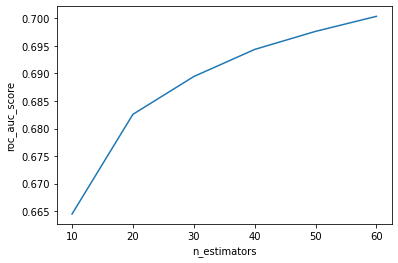

In [11]:
plt.plot(range(10, 70, 10), grad_boost_scores)
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')
plt.show()

# Подход 2: логистическая регрессия

## Вопрос 1
**Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?**

In [12]:
C_param_values = 10.**np.arange(-5, 5)

In [13]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_1), index=df_1.index, columns=df_1.columns)

In [14]:
log_reg_1_scores = []
log_reg_1_times = []
for C in C_param_values:
    start = datetime.datetime.now()
    log_reg = LogisticRegression(random_state=192, C=C)
    log_reg_1_scores.append(cross_val_score(log_reg, df_scaled, target, scoring='roc_auc', cv=kfold))
    log_reg_1_times.append(datetime.datetime.now() - start)

Качество модели и время обучения на кроссвалидации в зависимости от параметра C.

In [15]:
log_reg_1_scores = np.array(list(map(np.mean, log_reg_1_scores)))
pd.DataFrame({'score': log_reg_1_scores, 'time, sec': map(methodcaller('total_seconds'), log_reg_1_times)}, index=C_param_values)

,score,"time, sec"
0.00001,0.695006,4.645815
0.00010,0.711085,5.606818
0.00100,0.716015,9.046581
0.01000,0.716187,12.890351
0.10000,0.716163,13.233933
1.00000,0.716158,13.233931
10.00000,0.716158,13.406597
100.00000,0.716158,13.343301
1000.00000,0.716158,13.218307
10000.00000,0.716158,13.452678


График качества модели от параметра C.

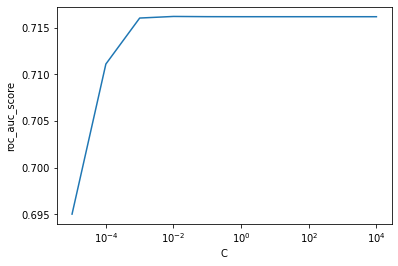

In [16]:
plt.plot(C_param_values, log_reg_1_scores)
plt.xlabel('C')
plt.ylabel('roc_auc_score')
plt.xscale('log')
plt.show()

Значение параметра C, при котором качество достигает максимума.

In [17]:
C_param_values[log_reg_1_scores.argmax()]

0.01

Максимальное качество

In [18]:
log_reg_1_scores.max()

0.7161868008507322

Таким образом, качество логистической регрессии 0.716187 получилось выше качества градиентного бустинга 0.700355 на 60 деревьях. Это может быть связано с тем, что количество деревьев недостаточное, ведь качество модели только увеличивалось. Также это может быть связано с качеством данных. Например, категориальные признаки были использованы как числовые, использован признак время начала. Логистическая регрессия работает быстрее в 811.2/12.5 = 64.896 раз по сравнению с градиентным бустингом на 60 деревьях.

## Вопрос 2
**Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?**

In [19]:
dropped_features = ['lobby_type'] + [f'{team}{n}_hero' for team, n in product(['r', 'd'], range(1, 6))]

In [20]:
df_2 = df_scaled.drop(dropped_features, axis=1)

In [21]:
log_reg_2_scores = []
log_reg_2_times = []
for C in C_param_values:
    start = datetime.datetime.now()
    log_reg = LogisticRegression(random_state=192, C=C)
    log_reg_2_scores.append(cross_val_score(log_reg, df_2, target, scoring='roc_auc', cv=kfold))
    log_reg_2_times.append(datetime.datetime.now() - start)

Качество модели и время обучения на кроссвалидации в зависимости от параметра C.

In [22]:
log_reg_2_scores = np.array(list(map(np.mean, log_reg_2_scores)))
pd.DataFrame({'score': log_reg_2_scores, 'time, sec': map(methodcaller('total_seconds'), log_reg_2_times)}, index=C_param_values)

,score,"time, sec"
0.00001,0.694947,4.772420
0.00010,0.711086,5.171600
0.00100,0.716059,8.577838
0.01000,0.716234,12.858946
0.10000,0.716213,13.024294
1.00000,0.716210,13.408189
10.00000,0.716209,12.838018
100.00000,0.716209,13.513581
1000.00000,0.716209,14.133208
10000.00000,0.716209,13.347745


График качества модели от параметра C.

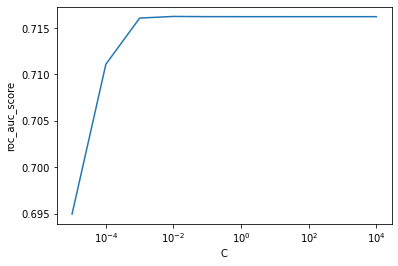

In [23]:
plt.plot(C_param_values, log_reg_2_scores)
plt.xlabel('C')
plt.ylabel('roc_auc_score')
plt.xscale('log')
plt.show()

Значение параметра C, при котором качество достигает максимума.

In [24]:
C_param_values[log_reg_2_scores.argmax()]

0.01

Максимальное качество

In [25]:
log_reg_2_scores.max()

0.7162342365982566

Качество стало 0.716234, оно увеличилось ненамного — на 0.716234-0.716187=0.000047=4.7e-5. Это связано с тем, что веса удаленных признаков в логистической регрессии было небольшим. 

## Вопрос 3
**Сколько различных идентификаторов героев существует в данной игре?**

In [26]:
len(heroes.index)

112

Значит, всего в данной игре 112 различных героев.

## Вопрос 4
**Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?**

In [27]:
N = len(heroes.index)
X_pick = np.zeros((df_1.shape[0], N))
for i, match_id in enumerate(df_1.index):
    for p in range(5):
        X_pick[i, df_1.loc[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick[i, df_1.loc[match_id, 'd%d_hero' % (p + 1)] - 1] = -1

In [28]:
df_3 = df_2.copy()

In [29]:
df_3[[f'hero_{i}' for i in heroes.index]] = X_pick

In [30]:
log_reg_3_scores = []
log_reg_3_times = []
for C in C_param_values:
    start = datetime.datetime.now()
    log_reg = LogisticRegression(random_state=192, C=C)
    log_reg_3_scores.append(cross_val_score(log_reg, df_3, target, scoring='roc_auc', cv=kfold))
    log_reg_3_times.append(datetime.datetime.now() - start)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Качество модели и время обучения на кроссвалидации в зависимости от параметра C.

In [31]:
log_reg_3_scores = np.array(list(map(np.mean, log_reg_3_scores)))
pd.DataFrame({'score': log_reg_3_scores, 'time, sec': map(methodcaller('total_seconds'), log_reg_3_times)}, index=C_param_values)

,score,"time, sec"
0.00001,0.699011,7.088208
0.00010,0.724767,8.812205
0.00100,0.746009,18.567501
0.01000,0.751485,31.200797
0.10000,0.751720,38.881069
1.00000,0.751706,39.248072
10.00000,0.751707,39.396234
100.00000,0.751706,40.477075
1000.00000,0.751706,39.097379
10000.00000,0.751706,39.827926


График качества модели от параметра C.

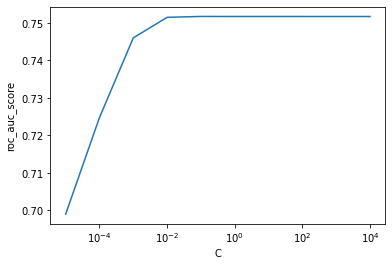

In [32]:
plt.plot(C_param_values, log_reg_3_scores)
plt.xlabel('C')
plt.ylabel('roc_auc_score')
plt.xscale('log')
plt.show()

Значение параметра C, при котором качество достигает максимума.

In [33]:
C_param_values[log_reg_3_scores.argmax()]

0.1

Максимальное качество

In [34]:
log_reg_3_scores.max()

0.7517199228284378

Качество на новых данных равно 0.751520, достигается при C=0.1. Оно несомненно увеличилось. Это связано с тем, что категориальная переменная теперь закодирована и используется именно как категориальная, а не числовая.

## Вопрос 5
**Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?**

In [35]:
features_test = pd.read_csv('data/features_test.csv', index_col='match_id')

Преобразование данных, как и тренировочных

In [36]:
features_test.fillna(value=0, inplace=True)
test_df_scaled = pd.DataFrame(StandardScaler().fit_transform(features_test), index=features_test.index, columns=features_test.columns)

In [37]:
N = len(heroes.index)
X_pick_test = np.zeros((features_test.shape[0], N))
for i, match_id in enumerate(features_test.index):
    for p in range(5):
        X_pick_test[i, features_test.loc[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick_test[i, features_test.loc[match_id, 'd%d_hero' % (p + 1)] - 1] = -1

In [38]:
test_df_scaled[[f'hero_{i}' for i in heroes.index]] = X_pick_test
test_df_scaled.drop(dropped_features, axis=1, inplace=True)

Тренировка лучшей модели

In [39]:
log_reg_best = LogisticRegression(random_state=192, C=0.1)

In [40]:
log_reg_best.fit(df_3, target)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, random_state=192)

In [41]:
predicted = log_reg_best.predict_proba(test_df_scaled)

In [42]:
predicted_r_win = predicted[:, 1]

Минимальное значение прогноза

In [43]:
predicted_r_win.min()

0.008583784557471335

Максимальное значение прогноза

In [44]:
predicted_r_win.max()

0.9964598059905446

Минимальное значение прогноза - 0.00858  
Максимальное значение прогноза - 0.99646

# My experiments

I tried to fill nans with -10000 and 10000 as outliers, 0 and the mean values as default. I used logistic regression, gradient and adaptive boostings, kNN method, SGD and stacking. Also I reduced the dimension of the data in case filling nans with -10000.

In [1]:
import datetime
from functools import reduce
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from operator import methodcaller
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.manifold import MDS

In [2]:
heroes = pd.read_csv('data/dictionaries/heroes.csv', index_col='id')
lobbies = pd.read_csv('data/dictionaries/lobbies.csv', index_col='id')
features = pd.read_csv('data/features.csv', index_col='match_id')

In [3]:
features.lobby_type.value_counts()

1    55962
7    28550
0    12718
Name: lobby_type, dtype: int64

In [3]:
class StackingEnsemble:
    """
    Stacking ensemble
    ---------
    layers: list of lists of classifiers
    
    It consists of the lists of classifiers used in
    layers for stacking. The last layer must consist of 1 classifier
    otherwise the exception will be thrown"""
    def __init__(self, layers):
        assert len(layers[-1]) == 1
        assert type(layers) is list
        assert all(map(lambda layer: type(layer) is list, layers))
        self.layers = []
        for layer in layers:
            self.layers.append(layer.copy())
        self.n_layers = len(self.layers)
    
    def fit(self, X, y):
        current_X = X.copy()
        current_y = y.copy()
        for i, layer in enumerate(self.layers):
            if i == self.n_layers - 1:
                layer[0].fit(current_X, current_y)
                break
            X_train, X_test, y_train, y_test = train_test_split(current_X, current_y,
                                                                train_size=len(current_X) // (self.n_layers - i))
            for clf in layer:
                clf.fit(X_train, y_train)
            current_X = pd.DataFrame({
                k: clf.predict(X_test)
                for k, clf in enumerate(layer)
            })
            current_y = y_test
    
    def predict(self, X):
        current_X = X.copy()
        for layer in self.layers:
            current_X = pd.DataFrame({
                k: clf.predict(current_X)
                for k, clf in enumerate(layer)
            })
        return current_X
    
    def predict_proba(self, X):
        current_X = X.copy()
        for layer in self.layers:
            current_X = pd.DataFrame({
                k: clf.predict_proba(current_X)[:, 1]
                for k, clf in enumerate(layer)
            })
        return current_X

In [4]:
class MyTransformer(BaseEstimator, TransformerMixin):

    def __all_gamer_features(self, feature_name):
        return [f'{team}{num}_{feature_name}' for team, num in product(['r', 'd'], range(1, 6))]

    def __init__(self):
        self.__gamer_features = ['hero', 'level', 'xp',
                                 'gold', 'lh', 'kills', 'deaths', 'items']
        self.__hero_features = self.__all_gamer_features('hero')
        self.__hero_encoder = OneHotEncoder(categories=[sorted(
            list(heroes.index)) for f in self.__hero_features], sparse=False)
        
        self.__lobby_type_encoder = OneHotEncoder(
            categories=[lobbies.index.to_list()], sparse=False)
        
        self.__first_blood_team_encoder = OneHotEncoder(
            categories=[[-1, 0, 1]], sparse=False)
        
        self.__time_features = ['first_blood_time',
                                'radiant_bottle_time',
                                'radiant_courier_time',
                                'radiant_flying_courier_time',
                                'radiant_first_ward_time',
                                'dire_bottle_time',
                                'dire_courier_time',
                                'dire_flying_courier_time',
                                'dire_first_ward_time']
        self.__time_features_encoder = SimpleImputer(strategy='constant', fill_value=-10000)

    def fit(self, X):
        self.__hero_encoder.fit(X[self.__all_gamer_features('hero')])
        self.__lobby_type_encoder.fit(X[['lobby_type']])
        self.__time_features_encoder.fit(X[self.__time_features])
        return self

    def transform(self, X):
        X_transformed = X.copy().drop(self.__hero_features +
                                      self.__all_gamer_features('level'), axis=1)

        hero_info = self.__hero_encoder.transform(X[self.__hero_features])
        r_hero_team = sum(np.array(
            X[f'r{k + 1}_level']).reshape((-1, 1)) * hero_info[:, 112*k:112*(k+1)] for k in range(5))
        d_hero_team = sum(
            np.array(X[f'd{k - 4}_hero']).reshape((-1, 1)) * hero_info[:, 112*k:112*(k+1)] for k in range(5, 10))

        X_transformed[[
            f'r_hero_{hero_index}' for hero_index in heroes.index]] = r_hero_team
        X_transformed[[
            f'd_hero_{hero_index}' for hero_index in heroes.index]] = d_hero_team

        for team, gamer_feature in product(['r', 'd'], self.__gamer_features[2:]):
            X_transformed[f'{team}_team_{gamer_feature}'] = X_transformed[[
                f'{team}{k}_{gamer_feature}' for k in range(1, 6)]].sum(axis=1)
            X_transformed.drop(
                [f'{team}{k}_{gamer_feature}' for k in range(1, 6)], axis=1, inplace=True)

        X_transformed[[f'lobby_type_{k}' for k in lobbies.index]] =\
            self.__lobby_type_encoder.transform(X_transformed[['lobby_type']])
        X_transformed.drop('lobby_type', axis=1, inplace=True)

        first_blood_team = self.__first_blood_team_encoder.fit_transform(
            X_transformed[['first_blood_team']].fillna(-1))
        X_transformed['was_first_blood'] = 1 - first_blood_team[:, 0]
        X_transformed['first_blood_r'] = first_blood_team[:, 1]
        X_transformed.drop(['first_blood_player1', 'first_blood_player2',
                           'first_blood_team'], axis=1, inplace=True)

        X_transformed[self.__time_features] = self.__time_features_encoder.transform(X_transformed[self.__time_features])
        
        return X_transformed

In [5]:
tr = MyTransformer().fit(features)
transformed_features = tr.transform(features)

KeyboardInterrupt: 

In [3]:
X = pd.read_csv('data/X.csv', index_col='match_id')
y = pd.read_csv('data/y.csv', index_col='match_id')

In [4]:
print([i for i in heroes.index if (X[f'r_hero_{i}'] == 0).all()])

[108, 109, 111, 113]


In [5]:
print([i for i in lobbies.index if (X[f'lobby_type_{i}'] == 0).all()])

[-1, 2, 3, 4, 5, 6, 8]


So these columns contains only zeros. They can be removed

In [4]:
columns_to_drop = ['start_time'] + [f'lobby_type_{k}' for k in [-1, 2, 3, 4, 5, 6, 8]] +\
                                        [f'{team}_hero_{hero}' for team, hero in product(['r', 'd'], [108, 109, 111, 113])]

In [5]:
X.drop(columns=columns_to_drop, inplace=True)

In [6]:
X_with_nans = X.replace(to_replace=-10000, value=np.nan)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=148)
y_train, y_test = y_train.radiant_win, y_test.radiant_win

## nan -> -10000

### simple data

#### gradient boosting

In [25]:
boosting = GradientBoostingClassifier(n_estimators=200, max_depth=8, random_state=163)
boosting.fit(X_train, y_train)
roc_auc_score(y_test, boosting.predict_proba(X_test)[:, 1])

0.7431592567898898

#### logistic regression

scaling of the data

In [31]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [31]:
log_reg = LogisticRegression()
log_reg.fit(scaled_X_train, y_train)
roc_auc_score(y_test, log_reg.predict_proba(scaled_X_test)[:, 1])

0.7545974774640416

#### adaptive boosting

200 trees

In [32]:
ada_boosting = AdaBoostClassifier(n_estimators=200)
ada_boosting.fit(X_train, y_train)
roc_auc_score(y_test, ada_boosting.predict_proba(X_test)[:, 1])

0.7490102036822612

1000 trees

In [33]:
big_ada_boosting = AdaBoostClassifier(n_estimators=1000, learning_rate=0.5)
big_ada_boosting.fit(X_train, y_train)
roc_auc_score(y_test, big_ada_boosting.predict_proba(X_test)[:, 1])

0.7521827389284013

adaptive boosting with log regression

In [30]:
log_reg_big_ada_boosting = AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=2000), n_estimators=50, learning_rate=0.5)
log_reg_big_ada_boosting.fit(X_train, y_train)
roc_auc_score(y_test, log_reg_big_ada_boosting.predict_proba(X_test)[:, 1])

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

0.7488524054994375

#### k-neighbors classifier

In [36]:
for n_neighbors in range(5, 50, 5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(scaled_X_train, y_train)
    print(f'{n_neighbors}:', roc_auc_score(y_test, knn.predict_proba(scaled_X_test)[:, 1]))

5: 0.5816251788171973
10: 0.60664683866342
15: 0.6209510757842787
20: 0.6331680764345905
25: 0.6406623276182621
30: 0.6484392491295679
35: 0.6528545688624756
40: 0.6586063986885088
45: 0.659705578619906


In [33]:
for n_neighbors in range(50, 500, 20):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(scaled_X_train, y_train)
    print(f'{n_neighbors}:', roc_auc_score(y_test, knn.predict_proba(scaled_X_test)[:, 1]))

50: 0.6623292388778497
70: 0.6733394793152506
90: 0.679879712185012
110: 0.6855493407827987
130: 0.6886124738788266
150: 0.6900543981364403
170: 0.6940017571498941
190: 0.6954340901167178
210: 0.6993666941129759
230: 0.7009065544000165
250: 0.702397128904565
270: 0.7048093835554009
290: 0.7068651133506796
310: 0.7089966678341102
330: 0.7112580728242189
350: 0.7123735436504092
370: 0.7134702132163538
390: 0.7149883275950653
410: 0.7157642370689565
430: 0.7166652517173626
450: 0.7173980401036707
470: 0.7177328614199358
490: 0.7190736825625939


In [32]:
knn = KNeighborsClassifier(n_neighbors=10000, weights='distance')
knn.fit(scaled_X_train, y_train)
print(f'{10000}:', roc_auc_score(y_test, knn.predict_proba(scaled_X_test)[:, 1]))

10000: 0.7256182211857578


### reduced data

In [10]:
pca = PCA(n_components=150)
pca.fit(X_train)

PCA(n_components=150)

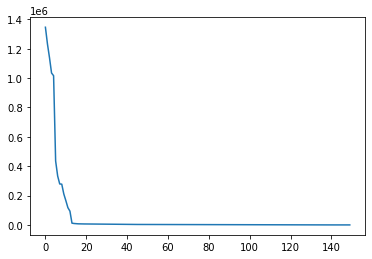

In [11]:
plt.plot(pca.singular_values_)
plt.show()

In [12]:
reduced_X_train = pca.transform(X_train)
reduced_X_test = pca.transform(X_test)

#### gradient boosting

In [20]:
boosting_2 = GradientBoostingClassifier(n_estimators=200, max_depth=8, random_state=163)
boosting_2.fit(reduced_X_train, y_train)
roc_auc_score(y_test, boosting_2.predict_proba(reduced_X_test)[:, 1])

0.7335875934561658

#### logistic regression

In [21]:
reduced_scaler = StandardScaler()
reduced_scaled_X_train = reduced_scaler.fit_transform(reduced_X_train)
reduced_scaled_X_test = reduced_scaler.transform(reduced_X_test)

In [22]:
reduced_log_reg = LogisticRegression()
reduced_log_reg.fit(reduced_scaled_X_train, y_train)
roc_auc_score(y_test, reduced_log_reg.predict_proba(reduced_scaled_X_test)[:, 1])

0.744805336253125

#### adaptive boosting

200 trees

In [23]:
reduced_ada_boosting = AdaBoostClassifier(n_estimators=200)
reduced_ada_boosting.fit(reduced_X_train, y_train)
roc_auc_score(y_test, reduced_ada_boosting.predict_proba(reduced_X_test)[:, 1])

0.7351100506611874

## nan -> mean

In [16]:
X_with_mean = X_with_nans.fillna(value=X_with_nans.mean())

In [17]:
X_with_mean_train, X_with_mean_test, y_with_mean_train, y_with_mean_test = train_test_split(X_with_mean, y, test_size=0.2, shuffle=True, random_state=148)
y_with_mean_train, y_with_mean_test = y_with_mean_train.radiant_win, y_with_mean_test.radiant_win

### gradient boosting

In [18]:
boosting_with_mean = GradientBoostingClassifier(n_estimators=200, max_depth=8, random_state=163)
boosting_with_mean.fit(X_with_mean_train, y_with_mean_train)
roc_auc_score(y_with_mean_test, boosting_with_mean.predict_proba(X_with_mean_test)[:, 1])

0.7452443006627629

### logistic regression

scaling of the data

In [19]:
scaler_mean = StandardScaler()
scaled_X_with_mean_train = scaler_mean.fit_transform(X_with_mean_train)
scaled_X_with_mean_test = scaler_mean.transform(X_with_mean_test)

the quality of model

In [20]:
log_reg_with_mean = LogisticRegression()
log_reg_with_mean.fit(scaled_X_with_mean_train, y_with_mean_train)
roc_auc_score(y_with_mean_test, log_reg_with_mean.predict_proba(scaled_X_with_mean_test)[:, 1])

0.7542446069379405

### adaptive boosting

200 trees

In [21]:
ada_boosting_with_mean = AdaBoostClassifier(n_estimators=200)
ada_boosting_with_mean.fit(X_with_mean_train, y_with_mean_train)
roc_auc_score(y_with_mean_test, ada_boosting_with_mean.predict_proba(X_with_mean_test)[:, 1])

0.7490294815941752

1000 trees

In [23]:
big_ada_boosting_with_mean = AdaBoostClassifier(n_estimators=1000, learning_rate=0.5)
big_ada_boosting_with_mean.fit(X_with_mean_train, y_with_mean_train)
roc_auc_score(y_with_mean_test, big_ada_boosting_with_mean.predict_proba(X_with_mean_test)[:, 1])

0.7518642826527444

## nan -> 0

In [8]:
X_with_zeroes = X_with_nans.fillna(value=0)

In [9]:
X_with_zeroes_train, X_with_zeroes_test, y_with_zeroes_train, y_with_zeroes_test = train_test_split(X_with_zeroes, y, test_size=0.2, shuffle=True, random_state=148)
y_with_zeroes_train, y_with_zeroes_test = y_with_zeroes_train.radiant_win, y_with_zeroes_test.radiant_win

### gradient boosting

In [10]:
boosting_with_zeroes = GradientBoostingClassifier(n_estimators=200, max_depth=8, random_state=163)
boosting_with_zeroes.fit(X_with_zeroes_train, y_with_zeroes_train)
roc_auc_score(y_with_zeroes_test, boosting_with_zeroes.predict_proba(X_with_zeroes_test)[:, 1])

0.7434506498430518

### logistic regression

scaling of the data

In [11]:
scaler_zeroes = StandardScaler()
scaled_X_with_zeroes_train = scaler_zeroes.fit_transform(X_with_zeroes_train)
scaled_X_with_zeroes_test = scaler_zeroes.transform(X_with_zeroes_test)

In [12]:
log_reg_with_zeroes = LogisticRegression()
log_reg_with_zeroes.fit(scaled_X_with_zeroes_train, y_with_zeroes_train)
roc_auc_score(y_with_zeroes_test, log_reg_with_zeroes.predict_proba(scaled_X_with_zeroes_test)[:, 1])

0.7543449050411899

### adaptive boosting

In [14]:
big_ada_boosting_with_zeroes = AdaBoostClassifier(n_estimators=1000, learning_rate=0.5)
big_ada_boosting_with_zeroes.fit(X_with_zeroes_train, y_with_zeroes_train)
roc_auc_score(y_with_zeroes_test, big_ada_boosting_with_zeroes.predict_proba(X_with_zeroes_test)[:, 1])

0.7517583388752915

## nan -> 10000

In [10]:
X_with_10000 = X_with_nans.fillna(value=10000)

In [11]:
X_with_10000_train, X_with_10000_test, y_with_10000_train, y_with_10000_test = train_test_split(X_with_10000, y, test_size=0.2, shuffle=True, random_state=148)
y_with_10000_train, y_with_10000_test = y_with_10000_train.radiant_win, y_with_10000_test.radiant_win

### logistic regression

scaling of the data

In [12]:
scaler_10000 = StandardScaler()
scaled_X_with_10000_train = scaler_10000.fit_transform(X_with_10000_train)
scaled_X_with_10000_test = scaler_10000.transform(X_with_10000_test)

In [13]:
log_reg_with_10000 = LogisticRegression()
log_reg_with_10000.fit(scaled_X_with_10000_train, y_with_10000_train)
roc_auc_score(y_with_10000_test, log_reg_with_10000.predict_proba(scaled_X_with_10000_test)[:, 1])

0.7546451002618246

### SGD

In [18]:
sgd_with_10000 = SGDClassifier(loss='log')
sgd_with_10000.fit(scaled_X_with_10000_train, y_with_10000_train)
roc_auc_score(y_with_10000_test, sgd_with_10000.predict_proba(scaled_X_with_10000_test)[:, 1])

0.7296182184317705

### adaptive boosting

In [14]:
big_ada_boosting_with_10000 = AdaBoostClassifier(n_estimators=1000, learning_rate=0.5)
big_ada_boosting_with_10000.fit(X_with_10000_train, y_with_10000_train)
roc_auc_score(y_with_10000_test, big_ada_boosting_with_10000.predict_proba(X_with_10000_test)[:, 1])

0.7522607403258381

### stacking

In [29]:
stacking_with_10000 = StackingEnsemble(
    layers=[
        [LogisticRegression(max_iter=100),
         LogisticRegression(max_iter=400),
         LogisticRegression(max_iter=700),
         LogisticRegression(max_iter=1000),
         LogisticRegression(max_iter=1300)]
        for k in range(5)] + [[LogisticRegression(max_iter=1000)]])
stacking_with_10000.fit(scaled_X_with_10000_train, y_with_10000_train)
roc_auc_score(y_with_10000_test, stacking_with_10000.predict_proba(scaled_X_with_10000_test))

0.7456590723521748

## logistic regression

the dependency of quality from the value to fill nan fields.

In [19]:
values = list(range(-9000, 0, 1000)) + [-300, 300] + list(range(1000, 10000, 1000))
for value in values:
    X_log_reg = X_with_nans.fillna(value=value)
    X_log_reg_train, X_log_reg_test, y_log_reg_train, y_log_reg_test = train_test_split(X_log_reg, y, test_size=0.2, shuffle=True, random_state=148)
    y_log_reg_train, y_log_reg_test = y_log_reg_train.radiant_win, y_log_reg_test.radiant_win
    scaler_mean = StandardScaler()
    scaled_X_log_reg_train = scaler_mean.fit_transform(X_log_reg_train)
    scaled_X_log_reg_test = scaler_mean.transform(X_log_reg_test)
    log_reg = LogisticRegression()
    log_reg.fit(scaled_X_log_reg_train, y_log_reg_train)
    print('%d: %f' % (value, roc_auc_score(y_log_reg_test, log_reg.predict_proba(scaled_X_log_reg_test)[:, 1])))

-9000: 0.754595
-8000: 0.754593
-7000: 0.754587
-6000: 0.754580
-5000: 0.754572
-4000: 0.754562
-3000: 0.754548
-2000: 0.754513
-1000: 0.754423
-300: 0.754261
300: 0.755076
1000: 0.754811
2000: 0.754719
3000: 0.754682
4000: 0.754667
5000: 0.754658
6000: 0.754651
7000: 0.754649
8000: 0.754645
9000: 0.754644


## xgb

In [31]:
from xgboost import XGBClassifier
import warnings

In [34]:
warnings.filterwarnings("ignore")

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
scores = {}
for max_depth in range(1, 7):
    xgb = XGBClassifier(n_estimators=1500, max_depth=max_depth)
    xgb.fit(X_train, y_train)
    scores[max_depth] = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

[12:08:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:12:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [37]:
scores

{1: 0.753625425828684,
 2: 0.7503018290766309,
 3: 0.7400856956145876,
 4: 0.7287012200640904,
 5: 0.7209582573360797,
 6: 0.7194739799296812}

## lightgbm

In [16]:
from lightgbm import LGBMClassifier

In [29]:
for n_estimators in range(1000, 2001, 200):
    print(n_estimators, 'trees')
    for max_depth in range(1, 10):
        lgbm = LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth)
        lgbm.fit(X_train, y_train)
        print(f'{max_depth}: {roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])}')
    print('----------------------------')

1000 trees
1: 0.748664022167904
2: 0.7534958613130069
3: 0.7527666478142105
4: 0.7498132187476846
5: 0.7468194331732508
6: 0.7443094172652662
7: 0.7432305426949344
8: 0.7415394143529244
9: 0.7441250695845234
----------------------------
1200 trees
1: 0.7499540322427314
2: 0.7540388417089064
3: 0.7527141525771524
4: 0.749187491622185
5: 0.7461575864435604
6: 0.7424779203030997
7: 0.7418771909095324
8: 0.7396503590537575
9: 0.7429370629666918
----------------------------
1400 trees
1: 0.7508249383940959
2: 0.754320977127446
3: 0.7525706592405044
4: 0.7483040760125947
5: 0.7446140188657671
6: 0.74059010429827
7: 0.7408662868670866
8: 0.7382585891438982
9: 0.7419853590614369
----------------------------
1600 trees
1: 0.7514889035756448
2: 0.7542900265457906
3: 0.7521138680584755
4: 0.7474307230493336
5: 0.7435488718634797
6: 0.7389608029737557
7: 0.7394080293456425
8: 0.7371881777887419
9: 0.7406052300445412
----------------------------
1800 trees
1: 0.7519862737030268
2: 0.754354522812628

In [24]:
lgbm = LGBMClassifier(n_estimators=2000, max_depth=2)
lgbm.fit(X_train, y_train)
print(f'{max_depth}: {roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])}')

5: 0.754319134074329


## Conclusion

The logistic regression is the best classifier in each case. The best value to fill the nans is 300 for logistic regression. The best quality is 0.755076

The best xgboost case is 1500 trees and max_depth equals 1. The score is 0.7536.
The best lightgbm case is 1800 trees and max_depth equals 2. The score is 0.7543.